In [279]:
!pip install --pre deepchem
!pip install -q condacolab
!pip install pubchempy
!pip install seaborn
#importing conda in colab
import condacolab
condacolab.install()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached deepchem-2.6.1-py3-none-any.whl (608 kB)
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 24.8 MB 65.7 MB/s 
     |████████████████████████████████| 15.7 MB 32.0 MB/s 
  Using cached rdkit_pypi-2022.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.8 MB)
     |████████████████████████████████| 306 kB 52.4 MB/s 
     |████████████████████████████████| 11.3 MB 38.0 MB/s 
     |████████████████████████████████| 247 kB 38.1 MB/s 
     |████████████████████████████████| 503 kB 38.8 MB/s 
     |████████████████████████████████| 3.1 MB 31.1 MB/s 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached PubChemPy-1.0.4-py3-none-any.whl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 5.4 MB/s 
     |████████████████████████████████| 11.2 MB 49.9 MB/s 
     |████████████████████████████████| 944 kB 53.7 MB/s 
     |████████████████████████████████| 40 kB 2.6 MB/s 
     |████████████████████████████████| 98 kB 5.7 MB/s 
     |████████████████████████████████| 1.1 MB 53.7 MB/s 


✨🍰✨ Everything looks OK!


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#libraries importing
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import AllChem

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

import pandas as pd
import numpy as np
import tensorflow as tf

from deepchem.molnet import load_pdbbind
from deepchem.models import AtomicConvModel
from deepchem.feat import AtomicConvFeaturizer

In [2]:
#if the dataset is present just press cancel when asks for uploading and carry on
from google.colab import files
uploaded = files.upload()

Saving activity_data.csv to activity_data.csv


In [3]:
#retrieving the name of the file just uploaded
name=" "
if uploaded.keys():
  for fn in uploaded.keys():
    name = fn

In [4]:
#load the dataset
name = "activity_data.csv" if name == " " else name
dataset_pandas = pd.read_csv(name)
# array of smiles
SMILES = dataset_pandas['SMILES']
# list with values and converted to mols
IC50 = []

In [5]:
# fluorescent pIC50
pIC50 = dataset_pandas['p_IC50']
# rapidfire pIC50
# pIC50 = dataset_pandas['r_pIC50']
for i in range(len(pIC50)):
  try:
    if float(pIC50[i]) < 6.00: 
      IC50.append(float(0))
    else:
      IC50.append(float(1))
  except:
     None

for value in range(len(pIC50)):
  try:
    if pIC50[value] == "#NUM!":
      dataset_pandas.drop(value,axis=0, inplace=True)
    elif pIC50[value] == " ":
      dataset_pandas.drop(value,axis=0, inplace=True)
    else: 
      continue
  except:
      None
    


In [6]:
# dataframe object
dataset_mol = pd.DataFrame(list(zip(SMILES, IC50)), columns=["smiles", "IC50"])

In [202]:
def count_labels(array_data):
  '''Counting the labels inside the dataset zero and ones'''
  counter_ones = 0
  counter_zeros = 0
  for value in range(len(array_data)):
    if array_data[value] == float(1):
      counter_ones += 1
    else:
      counter_zeros += 1
  
  print(f"These are the 1s: {counter_ones}", "\n"
        f"These are the 0s: {counter_zeros}")
# output for fluorescent
# (466, 1925)

In [234]:
# featurization fingerprint
# featurizer = dc.feat.CircularFingerprint(size=2048, radius = 2, chiral=True)
featurizer = dc.feat.MACCSKeysFingerprint()

In [235]:
#dataset creation
import tempfile
with dc.utils.UniversalNamedTemporaryFile(mode='w') as tmpfile:
  dataset_mol.to_csv(tmpfile.name) #transforms the dataset in a .csv
  loader = dc.data.CSVLoader(["IC50"], feature_field="smiles", featurizer=featurizer) #it loads it as a csv and featurizes the whole
  dataset = loader.create_dataset(tmpfile.name) #creates the datasaet returning four arrays

# dataset.X has the data which is the featurized SMILES
# y has the respective labels
# w has the weights
# ids is composed of the ids which in this case are the SMILES
print(dataset.X.shape,
      dataset.y.shape,
      dataset.w.shape,
      dataset.ids.shape)

(1926, 167) (1926, 1) (1926, 1) (1926,)


In [236]:
# #see how featurization looks like
# for i in range(167):
#   print(dataset.X[0][i])

In [237]:
#splitter which returns three subsets, train_dataset, valid_dataset, and test_dataset
splitter = dc.splits.ScaffoldSplitter()

#using in case of no cross validation 
# Splitting the data
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset,
                                                                            frac_train = 0.8,
                                                                            frac_valid = 0.1,
                                                                            frac_test  = 0.1 )


# swapping valid and test due to easiest prediction in fluorescent pIC50
valid_dataset, test_dataset = (test_dataset, valid_dataset) if (len(dataset) > 1000) else (valid_dataset, test_dataset)

###########

#use this split in case of cros validation
training_data, testing_data = splitter.train_test_split(dataset, frac_train=0.75)

print(len(train_dataset), 
      len(valid_dataset),
      len(test_dataset),
     '##########',
      len(training_data), 
      len(testing_data))

1540 193 193 ########## 1444 482


In [238]:
# counting ones and zeros in the test set
count_labels(testing_data.y)

These are the 1s: 66 
These are the 0s: 416


In [170]:
# # # # transforming data -> Normalising the dataset to have a zero mean and unit standard deviation. 
# transformers = [dc.trans.NormalizationTransformer(transform_X=True, dataset=train_dataset)]

# for dataset in [train_dataset, valid_dataset, test_dataset]:
#   for transformer in transformers:
#       dataset = transformer.transform(dataset)

In [239]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve

In [240]:
# from time import thread_time
# getting scores after fitting the model
def get_scores(mode):
  y_pred          =    classifier.predict(mode.X)
  f1_scores       =    f1_score(mode.y.flatten(), y_pred, average='weighted')
  accuracy        =    accuracy_score(mode.y.flatten(), y_pred)
  roc_auc_scores  =    roc_auc_score(mode.y.flatten(),classifier.predict_proba(mode.X)[:, 1])
  conf_matrix     =    confusion_matrix(mode.y, y_pred)
  print(metrics.classification_report(mode.y, y_pred))
  print("Classifier:   " , classifier,              "\n",
        "Featurizer:   " , featurizer,              "\n", 
        f"F1_Score:       {f1_scores:.2%} " ,       "\n", 
        f"Roc_auc_score:  {roc_auc_scores:.2%} " ,  "\n",
        f"Accuracy Score: {accuracy:.2%} " )
  
  #setting up the confusion matrix with as many details as possible
  group_names       = ['True Neg','False Pos','False Neg','True Pos']
  group_counts      = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
  group_percentages = ["{:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
  labels            = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels            = np.asarray(labels).reshape(2,2)

  sns.heatmap(conf_matrix/np.sum(conf_matrix), 
              annot = labels, 
              fmt = '', 
              cmap= 'Blues',
              vmin= 0.0 ,
              vmax= 1.0 )

# Cross-Validation

In [241]:
# cross validation function
def cross_val(classifier, scoring: str):
  # splitting the datset in even parts
  def custom_cv_10folds(X):
    n = X.X.shape[0]
    i = 1
    while i <= 10:
      idx = np.arange(n * (i - 1) / 10, n * i / 10, dtype=int)
      yield idx, idx
      i += 1
  # cross validation
  custom_cv = custom_cv_10folds(training_data)

# use this if no graphs are needed (much faster)
  # f1 score
  # accuracy = cross_validate(classifier, 
  #                           training_data.X, 
  #                           training_data.y.flatten() ,
  #                           scoring='accuracy',
  #                           cv = custom_cv,
  #                           return_train_score=True)

  # train_mean, train_std = accuracy['train_score'].mean(), accuracy['train_score'].std()
  # valid_mean, valid_std = accuracy['test_score'].mean(), accuracy['test_score'].std()
  # print(train_scores, valid_scores)

  # print("Accuracy of Model with Cross Validation(Training) is:",train_mean, "(+/- %0.2f)" % train_std)

############

  train_sizes, train_scores, valid_scores = learning_curve(classifier,
                                                          training_data.X,
                                                          training_data.y.flatten(), 
                                                          cv= custom_cv,
                                                          scoring = scoring, 
                                                          train_sizes=np.linspace(0.1,1.0,20),
                                                          error_score = 0.90,
                                                          shuffle=True) 
  
  train_mean  = np.mean(train_scores, axis=1)
  train_std   = np.std(train_scores, axis=1)

  valid_mean  = np.mean(valid_scores, axis =1)
  valid_std   = np.std(valid_scores, axis=1)

  print("Accuracy of Model with Cross Validation(Training) is:  ",train_scores.mean(), "(+/- %0.2f)" % train_scores.std())
  print("Accuracy of Model with Cross Validation(Validation) is:",valid_scores.mean(), "(+/- %0.2f)" % valid_scores.std())
  

  # Plotting the graph
  plt.subplots(1, figsize=(7,7))
  plt.plot(train_sizes, train_mean, label="Training score")
  plt.plot(train_sizes, valid_mean, label="Cross-validation score")

  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
  plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color="#DDDDDD")

  plt.title("Learning Curve")
  plt.xlabel("Training Set Size"), plt.ylabel(scoring), plt.legend(loc="best")
  plt.tight_layout()
  plt.show()

# RandomForest Classifier

Accuracy of Model with Cross Validation(Training) is:   0.9574765705873696 (+/- 0.04)
Accuracy of Model with Cross Validation(Validation) is: 0.882448275862069 (+/- 0.08)


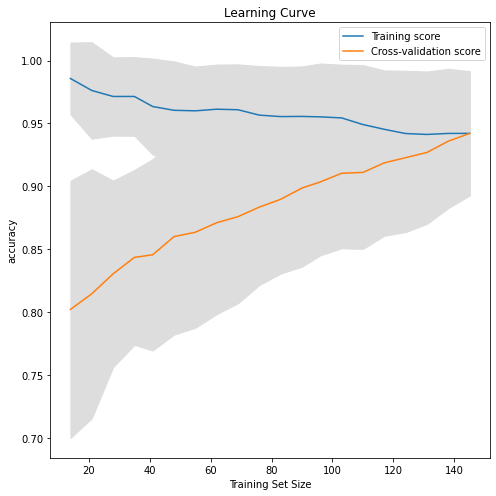

RandomForestClassifier(max_depth=13, n_estimators=300)

In [242]:
#training model RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

# declaring the model and hyperparameters
classifier = RandomForestClassifier(n_estimators=300, 
                                    criterion='gini', 
                                    max_depth=13, 
                                    random_state=None)
# cross validation
cross_val(classifier, 'accuracy')
# fitting the model
classifier.fit(training_data.X,training_data.y.flatten())

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96       416
         1.0       0.84      0.56      0.67        66

    accuracy                           0.93       482
   macro avg       0.89      0.77      0.82       482
weighted avg       0.92      0.93      0.92       482

Classifier:    RandomForestClassifier(max_depth=13, n_estimators=300) 
 Featurizer:    MACCSKeysFingerprint 
 F1_Score:       91.88%  
 Roc_auc_score:  87.85%  
 Accuracy Score: 92.53% 


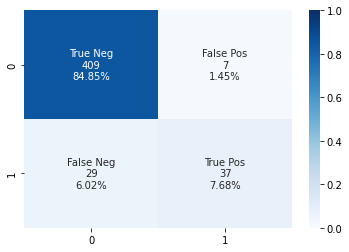

In [243]:
# retrieving scores
get_scores(testing_data)

# Logistic Regression

In [280]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver = 'liblinear', 
                                random_state = 0,
                                max_iter=300,
                                class_weight= 'balanced')

# cross validation
# cross_val(classifier, 'accuracy')

classifier.fit(training_data.X,training_data.y.flatten())

LogisticRegression(class_weight='balanced', max_iter=300, random_state=0,
                   solver='liblinear')

              precision    recall  f1-score   support

         0.0       0.95      0.88      0.92       416
         1.0       0.49      0.73      0.59        66

    accuracy                           0.86       482
   macro avg       0.72      0.80      0.75       482
weighted avg       0.89      0.86      0.87       482

Classifier:    LogisticRegression(class_weight='balanced', max_iter=300, random_state=0,
                   solver='liblinear') 
 Featurizer:    MACCSKeysFingerprint 
 F1_Score:       87.15%  
 Roc_auc_score:  90.66%  
 Accuracy Score: 86.10% 


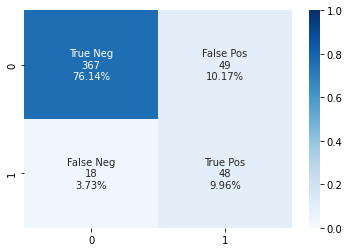

In [281]:
# get_scores(test_dataset)
get_scores(testing_data)

#Neural Network (MLP)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_m

Accuracy of Model with Cross Validation(Training) is:   0.9067360307647284 (+/- 0.14)
Accuracy of Model with Cross Validation(Validation) is: 0.8373448275862069 (+/- 0.13)


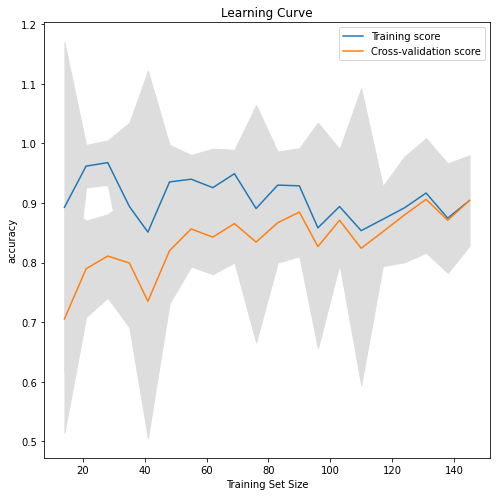

MLPClassifier(alpha=0.001, hidden_layer_sizes=(128, 3), max_iter=1000)

In [272]:
from sklearn.neural_network import MLPClassifier
#  {'lbfgs', 'sgd', 'adam'}, default='adam'
classifier = MLPClassifier(solver='adam', 
                           learning_rate='constant',
                           alpha=1e-3, 
                           hidden_layer_sizes=(128, 3), 
                           shuffle=True, 
                           batch_size="auto", 
                           max_iter=1000)

# cross validation
cross_val(classifier, 'accuracy')

# fitting the model
classifier.fit(training_data.X,training_data.y.flatten())

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       416
         1.0       0.74      0.42      0.54        66

    accuracy                           0.90       482
   macro avg       0.83      0.70      0.74       482
weighted avg       0.89      0.90      0.89       482

Classifier:    MLPClassifier(alpha=0.001, hidden_layer_sizes=(128, 3), max_iter=1000) 
 Featurizer:    MACCSKeysFingerprint 
 F1_Score:       88.86%  
 Roc_auc_score:  88.08%  
 Accuracy Score: 90.04% 


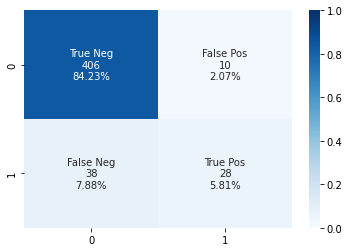

In [273]:
# get_scores(test_dataset)
get_scores(testing_data)

# Naive Bayes

Accuracy of Model with Cross Validation(Training) is:   0.8334772393530211 (+/- 0.09)
Accuracy of Model with Cross Validation(Validation) is: 0.796655172413793 (+/- 0.08)


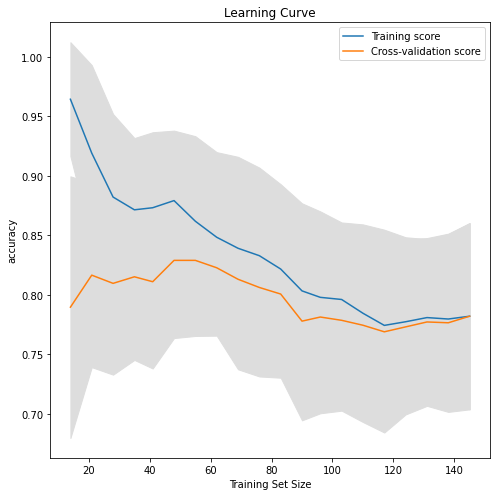

GaussianNB(var_smoothing=0.25)

In [261]:
from sklearn.naive_bayes import GaussianNB

# classifier = GaussianNB(var_smoothing=1e-3)
# for MACCS Keys 
classifier = GaussianNB(var_smoothing=25e-2)
# cross validation
cross_val(classifier, 'accuracy')


classifier.fit(train_dataset.X,train_dataset.y.flatten())

              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89       416
         1.0       0.40      0.71      0.51        66

    accuracy                           0.82       482
   macro avg       0.67      0.77      0.70       482
weighted avg       0.87      0.82      0.84       482

Classifier:    GaussianNB(var_smoothing=0.25) 
 Featurizer:    MACCSKeysFingerprint 
 F1_Score:       83.51%  
 Roc_auc_score:  86.72%  
 Accuracy Score: 81.54% 


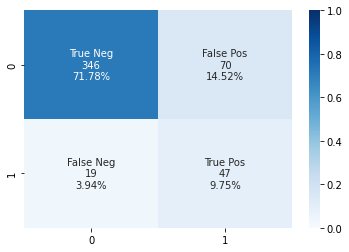

In [262]:
# get_scores(valid_dataset) 
get_scores(testing_data)

# Supporter Vector Machine (SVM)


In [263]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Accuracy of Model with Cross Validation(Training) is:   0.8887560028774781 (+/- 0.06)
Accuracy of Model with Cross Validation(Validation) is: 0.8447141595964408 (+/- 0.08)


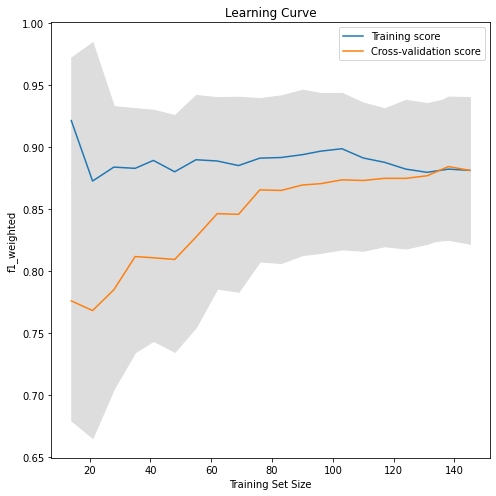

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))])

In [265]:
classifier = make_pipeline(StandardScaler(), 
                           SVC(kernel='rbf', 
                               probability=True))
# cross validation
cross_val(classifier, 'f1_weighted')

classifier.fit(training_data.X,training_data.y.flatten() )

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       416
         1.0       0.80      0.59      0.68        66

    accuracy                           0.92       482
   macro avg       0.87      0.78      0.82       482
weighted avg       0.92      0.92      0.92       482

Classifier:    Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))]) 
 Featurizer:    MACCSKeysFingerprint 
 F1_Score:       91.83%  
 Roc_auc_score:  83.98%  
 Accuracy Score: 92.32% 


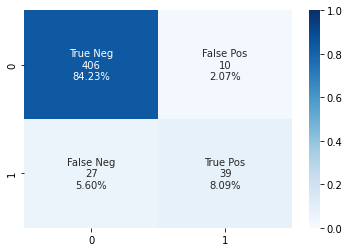

In [266]:
# get_scores(train_dataset)
get_scores(testing_data)

# Gradient Boosting

Accuracy of Model with Cross Validation(Training) is:   0.9606834020142614 (+/- 0.04)
Accuracy of Model with Cross Validation(Validation) is: 0.8651096215192408 (+/- 0.08)


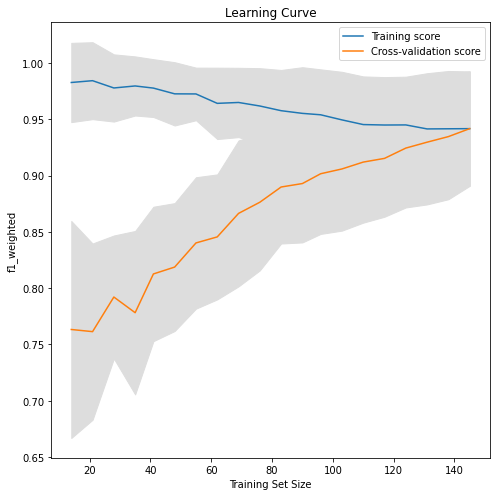

GradientBoostingClassifier(learning_rate=0.03, loss='exponential',
                           n_estimators=500, random_state=0)

In [267]:
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier(n_estimators=500, 
                                        loss='exponential',
                                        learning_rate=0.03,
                                        max_depth=3, 
                                        random_state=0)

# cross validation
cross_val(classifier, 'f1_weighted')

classifier.fit(train_dataset.X,train_dataset.y.flatten())

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       416
         1.0       0.83      0.52      0.64        66

    accuracy                           0.92       482
   macro avg       0.88      0.75      0.80       482
weighted avg       0.91      0.92      0.91       482

Classifier:    GradientBoostingClassifier(learning_rate=0.03, loss='exponential',
                           n_estimators=500, random_state=0) 
 Featurizer:    MACCSKeysFingerprint 
 F1_Score:       91.08%  
 Roc_auc_score:  92.10%  
 Accuracy Score: 91.91% 


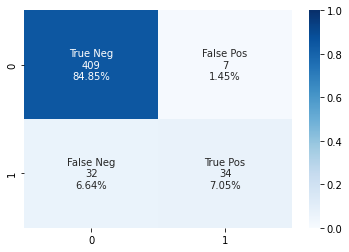

In [268]:
#get_scores(test_dataset)
get_scores(testing_data)

# K-N-Neighbors

Accuracy of Model with Cross Validation(Training) is:   0.9593779064704399 (+/- 0.04)
Accuracy of Model with Cross Validation(Validation) is: 0.8702302075663969 (+/- 0.08)


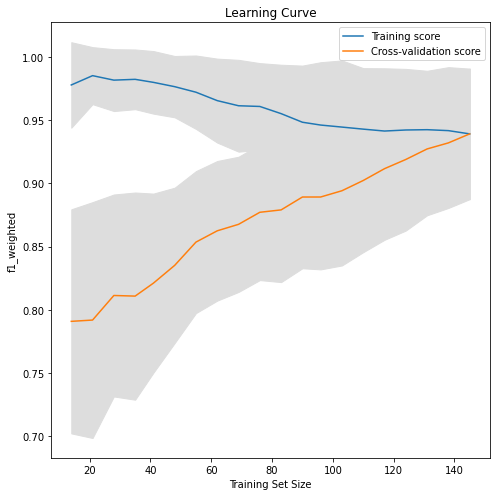

KNeighborsClassifier(algorithm='ball_tree', leaf_size=100, n_neighbors=3,
                     weights='distance')

In [269]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=3,
                                  weights='distance', 
                                  algorithm='ball_tree',
                                  p=2,
                                  leaf_size=100)
# cross validation
cross_val(classifier, 'f1_weighted')
# fitting the model
classifier.fit(train_dataset.X,train_dataset.y.flatten())

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94       416
         1.0       0.61      0.74      0.67        66

    accuracy                           0.90       482
   macro avg       0.79      0.83      0.81       482
weighted avg       0.91      0.90      0.90       482

Classifier:    KNeighborsClassifier(algorithm='ball_tree', leaf_size=100, n_neighbors=3,
                     weights='distance') 
 Featurizer:    MACCSKeysFingerprint 
 F1_Score:       90.43%  
 Roc_auc_score:  87.58%  
 Accuracy Score: 90.04% 


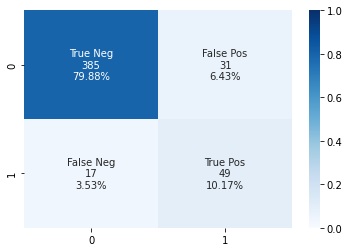

In [270]:
# get_scores(test_dataset)
get_scores(testing_data)
